Author: Filip Bucko  
Email: xbucko05@vutbr.cz  
Institution: Brno University of Technology - Faculty of Information Technology  
Date: 18.5.2024

# Malicious Domain Detection via RDAP Metadata

This notebook prepares RDAP (Registration Data Access Protocol) records for binary classification of domains (malicious vs. benign).

## Workflow Phases

1. **RDAP JSON Preprocessing**  
   Flatten and clean RDAP records exported from MongoDB.

2. **Missing Value Analysis**  
   Evaluate and filter fields based on missingness patterns and statistical tests.

3. **Transformer Input Preparation**  
   Construct a single text-based representation of each record suitable for transformer-based models.

## Output

- A cleaned and labeled CSV file with a column `input_string` for model input.


## Phase 1: RDAP JSON Preprocessing and Flattening

This phase loads raw RDAP data exported from MongoDB and transforms it into a flat, structured format suitable for downstream analysis.

**Input format:**  
A JSON Lines (`.jsonl`) file, where each line contains:
- `"domain_name"`: the domain under analysis
- `"rdap"`: a nested object with registration-related metadata

**Processing:**
- Load the file line by line into memory.
- Flatten nested RDAP fields using `pandas.json_normalize`.
- Drop any internal fields such as `"_id"` introduced by MongoDB.
- Remove the `"rdap."` prefix from all field names for cleaner access.

**Output:**  
A `pandas.DataFrame` with one row per domain and flattened RDAP fields as columns.


In [1]:
# Standard libraries
import json
import random
from pathlib import Path
from typing import Optional, List, Dict

# Data and analysis
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML


In [2]:
def render_dataframe(df: pd.DataFrame, max_rows: int = 100, max_cols: int = 50) -> HTML:
    """
    Display a styled HTML preview of a DataFrame in Jupyter.

    Args:
        df: DataFrame to render.
        max_rows: Number of rows to display.
        max_cols: Number of columns to display.

    Returns:
        IPython.display.HTML object with scrollable styling.
    """
    styles = [
        {"selector": "th", "props": [("max-width", "200px")]},
        {"selector": "td", "props": [("max-width", "200px"), ("overflow", "auto"), ("text-overflow", "ellipsis")]}
    ]

    return HTML(
        df.head(max_rows)
          .style.set_table_styles(styles)
          .set_table_attributes('style="display:inline-block; overflow:auto; max-height:500px;"')
          .to_html()
    )


def read_rdap_json_file(file_path: str) -> pd.DataFrame:
    """
    Load and flatten RDAP JSONL data into a tabular DataFrame.

    Args:
        file_path: Path to the RDAP JSONL file.

    Returns:
        Flattened pandas DataFrame with 'rdap.' prefix removed from columns.
    """
    with open(file_path, "r") as f:
        data = [json.loads(line) for line in f]

    df = pd.json_normalize(data, sep=".")

    # Drop MongoDB _id fields if present
    df.drop(columns=[col for col in df.columns if col.startswith("_id")], inplace=True, errors="ignore")

    # Remove rdap. prefix for cleaner column access
    df.columns = [col.replace("rdap.", "") for col in df.columns]

    return df


In [3]:
def _sample_jsonl_lines(
    file_path: str,
    sample_size: int,
    total_lines: int,
    seed: int
) -> List[Dict]:
    """
    Sample a fixed number of lines from a JSONL file using a two-pass strategy.

    Args:
        file_path: Path to the JSONL file.
        sample_size: Number of lines to sample.
        total_lines: Total number of lines in the file.
        seed: Random seed for reproducibility.

    Returns:
        A list of sampled JSON objects (as Python dictionaries).
    """
    random.seed(seed)
    selected_indices = set(random.sample(range(total_lines), sample_size))
    data = []

    with open(file_path, "r") as f:
        for i, line in enumerate(f):
            if i in selected_indices:
                data.append(json.loads(line))
            if len(data) >= sample_size:
                break  # Early exit

    return data


def read_rdap_json_file_to_df(
    file_path: str,
    sample_size: Optional[int] = None,
    seed: int = 42
) -> pd.DataFrame:
    """
    Load a RDAP JSONL file and return a flattened DataFrame.

    If sample_size is set, only that number of lines will be randomly sampled.

    Args:
        file_path: Path to the JSONL file.
        sample_size: Optional number of records to sample. If None, load full file.
        seed: Random seed for sampling.

    Returns:
        Flattened pandas DataFrame with cleaned column names.
    """
    with open(file_path, "r") as f:
        total_lines = sum(1 for _ in f)

    if sample_size is None or sample_size >= total_lines:
        with open(file_path, "r") as f:
            data = [json.loads(line) for line in f]
    else:
        data = _sample_jsonl_lines(file_path, sample_size, total_lines, seed)

    df = pd.json_normalize(data, sep=".")
    df.drop(columns=[col for col in df.columns if col.startswith("_id")], inplace=True, errors="ignore")
    df.columns = [col.replace("rdap.", "") for col in df.columns]

    return df


### Benign

In [4]:
# Resolve project root (assumes this notebook lives in /project_root/evaluation/)
project_root = Path.cwd().parent

# Path to the benign RDAP JSON file
benign_file_path = project_root/ ".." / "datasets" / "benign" / "benign_2312_anonymized_rdap_2024.json"

# Load a sample of the benign dataset
benign_df = read_rdap_json_file_to_df(benign_file_path, sample_size=160_000)

# Preview
render_dataframe(benign_df)


,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrant,entities.abuse,entities.admin,entities.registrar,nameservers,status,registration_date,expiration_date,entities.technical,entities.administrative,entities.billing,dnssec,rdap,last_changed_date,entities.sponsor,entities.zone,entities.tech,entities.reseller
0,00000fs3085d.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,0000100b00e9.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,0000100q012c.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,0000102n02c4.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,0000102n02d5.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,0000102n03d3.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,0000102n0434.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,000010560066.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,0000105600be.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9,000010640021.han2.savba.sk,,savba.sk,,,,[],2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [5]:
benign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              160000 non-null  object 
 1   handle                   104921 non-null  object 
 2   name                     104921 non-null  object 
 3   whois_server             104921 non-null  object 
 4   terms_of_service_url     104921 non-null  object 
 5   copyright_notice         104921 non-null  object 
 6   description              104921 non-null  object 
 7   last_changed_date.$date  87207 non-null   object 
 8   registration_date.$date  96981 non-null   object 
 9   expiration_date.$date    91816 non-null   object 
 10  url                      104921 non-null  object 
 11  entities.registrant      103373 non-null  object 
 12  entities.abuse           99417 non-null   object 
 13  entities.admin           63215 non-null   object 
 14  enti

### Malware

In [6]:
# Path to the malware RDAP JSON file
malware_file_path = project_root.parent / "datasets" / "malware" / "malware_strict_rdap_2024.json"

# Load the full malware dataset
malware_df = read_rdap_json_file_to_df(malware_file_path)

# Preview
render_dataframe(malware_df)


,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,expiration_date,rdap,last_changed_date,entities.administrative,entities.technical,entities.billing,registration_date,entities.sponsor,entities.reseller,entities.tech,entities.a,entities.d,entities.m,entities.i,entities.n,entities.s,entities.t,entities.r,entities.v,entities.e,entities.c,entities.h,entities.l,entities.b,entities.g,entities.zone
0,irradiateher.com,2740314140_DOMAIN_COM-VRSN,IRRADIATEHER.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,https://rdap.verisign.com/com/v1/domain/IRRADIATEHER.COM,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,eloquentcs.com,1808171119_DOMAIN_COM-VRSN,ELOQUENTCS.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,https://rdap.verisign.com/com/v1/domain/ELOQUENTCS.COM,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,www.neutralsystemsolution.space,,neutralsystemsolution.space,,,,[],2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],nan,[{'name': 'none'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,www.drshiwanijainpainclinic.com,,drshiwanijainpainclinic.com,,,,[],2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Domains By Proxy, LLC'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,mkt9136.com,2162099471_DOMAIN_COM-VRSN,MKT9136.COM,,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,,[],2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,https://rdap.verisign.com/com/v1/domain/MKT9136.COM,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,www.ninjacondoms.com,,ninjacondoms.com,,,,[],2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",nan,[{'name': ''}],[{'name': ''}],nan,na

In [7]:
malware_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100809 entries, 0 to 100808
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   domain_name              100809 non-null  object 
 1   handle                   75853 non-null   object 
 2   name                     75853 non-null   object 
 3   whois_server             75853 non-null   object 
 4   terms_of_service_url     75853 non-null   object 
 5   copyright_notice         75853 non-null   object 
 6   description              75853 non-null   object 
 7   last_changed_date.$date  70479 non-null   object 
 8   registration_date.$date  73628 non-null   object 
 9   expiration_date.$date    72260 non-null   object 
 10  url                      75853 non-null   object 
 11  entities.registrar       74393 non-null   object 
 12  entities.abuse           72985 non-null   object 
 13  nameservers              75853 non-null   object 
 14  stat

## Phase 2: Missing Value Analysis and Feature Filtering

This phase evaluates the RDAP fields for their usefulness in classification, based on missingness patterns across the benign and malicious datasets.

**Objective:**  
Remove columns that are uninformative due to excessive missing values or lack of class-based variation.

**Approach:**
- Replace empty strings and lists with proper `NaN` markers
- Identify fully empty columns and drop them
- Quantify missingness across datasets
- Use statistical tests (e.g. chi-square) to determine if missingness correlates with class label
- Drop features that are both highly missing and statistically uninformative


## Handling of missing values

### Columns with any NaN (missing values)
Before hadnling the Nan values, it is clear that some columns appear that they are not empty, because they do not contain NaN values. But this is false, because by analyzing the columns, it is clear that some of them contain empty strings '' or empty lists '[]'. Therefore, for better analysis will be these values replaced by NaN.

In [8]:
# Replace empty strings (or whitespace-only strings) with NaN
benign_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)
malware_df.replace(r"^\s*$", np.nan, regex=True, inplace=True)


def empty_lists_to_nan(val):
    """Convert empty lists to np.nan; leave all other values unchanged."""
    if isinstance(val, list) and len(val) == 0:
        return np.nan
    return val


# Apply to all cells: convert empty lists to NaN
benign_df = benign_df.applymap(empty_lists_to_nan)
malware_df = malware_df.applymap(empty_lists_to_nan)


/tmp/ipykernel_219508/3368118053.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  benign_df = benign_df.applymap(empty_lists_to_nan)
/tmp/ipykernel_219508/3368118053.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  malware_df = malware_df.applymap(empty_lists_to_nan)


In [9]:
# Summary of columns with missing values

print("Benign:")
benign_nan_cols = benign_df.columns[benign_df.isna().any()].tolist()
print(f"Columns with any NaN: {len(benign_nan_cols)}")
print(f"Total columns: {len(benign_df.columns)}")

print("\nMalware:")
malware_nan_cols = malware_df.columns[malware_df.isna().any()].tolist()
print(f"Columns with any NaN: {len(malware_nan_cols)}")
print(f"Total columns: {len(malware_df.columns)}")


Benign:
Columns with any NaN: 28
Total columns: 29

Malware:
Columns with any NaN: 43
Total columns: 44


### Columns That Are Fully Empty (All Values Are NaN)
These columns can be fully dropped

In [10]:
# Identify columns that are completely missing (100% NaN)

fully_nan_benign = benign_df.columns[benign_df.isna().all()].tolist()
fully_nan_malware = malware_df.columns[malware_df.isna().all()].tolist()

print("Benign fully-NaN columns:")
print(fully_nan_benign)

print("\nMalware fully-NaN columns:")
print(fully_nan_malware)


# Drop fully-NaN columns
print("\nDropping fully empty columns...")

print("Benign shape before:", benign_df.shape)
benign_df.drop(columns=fully_nan_benign, inplace=True)
print("Benign shape after:", benign_df.shape)

print("\nMalware shape before:", malware_df.shape)
malware_df.drop(columns=fully_nan_malware, inplace=True)
print("Malware shape after:", malware_df.shape)


Benign fully-NaN columns:
['registration_date', 'expiration_date', 'rdap', 'last_changed_date']

Malware fully-NaN columns:
['expiration_date', 'rdap', 'last_changed_date', 'registration_date']

Dropping fully empty columns...
Benign shape before: (160000, 29)
Benign shape after: (160000, 25)

Malware shape before: (100809, 44)
Malware shape after: (100809, 40)


In [11]:
# Show number of missing values per column in malware dataset (non-zero only)
missing_counts = malware_df.isna().sum()
print("Missing value counts (Malware, non-zero only):")
print(missing_counts[missing_counts > 0])

Missing value counts (Malware, non-zero only):
handle                      51508
name                        24956
whois_server                92569
terms_of_service_url        54611
copyright_notice           100702
description                100781
last_changed_date.$date     30330
registration_date.$date     27181
expiration_date.$date       28549
url                         53516
entities.registrar          26416
entities.abuse              27824
nameservers                 25793
status                      27922
dnssec                      51190
entities.registrant         59478
entities.admin              74571
entities.administrative     86293
entities.technical          86313
entities.billing            93261
entities.sponsor           100325
entities.reseller          100771
entities.tech              100805
entities.a                 100808
entities.d                 100808
entities.m                 100808
entities.i                 100808
entities.n                 100808
e

In [12]:
# Inspect 'entities.*' columns that contain exactly one non-null value in the malware dataset

suspicious_cols = [col for col in malware_df.columns if col.startswith("entities.")]
rare_non_null_info = []

for col in suspicious_cols:
    non_null_count = malware_df[col].notna().sum()
    if non_null_count == 1:
        row_index = malware_df[malware_df[col].notna()].index[0]
        rare_non_null_info.append((col, row_index))

# Display results
if rare_non_null_info:
    for col, idx in rare_non_null_info:
        print(f"\nColumn: {col}")
        print(f"Row index with non-null value: {idx}")
        print("Value:")
        print(malware_df.loc[idx, col])
else:
    print("No 'entities.*' columns with exactly one non-null value found.")



Column: entities.a
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.d
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.m
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.i
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.n
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.s
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.t
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.r
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.v
Row index with non-null value: 22374
Value:
[{'handle': 'PRIVATE', 'type': 'entity'}]

Column: entities.e
Row index with non-null va

In [13]:
# Compare schema between malware and benign datasets

common_columns = set(malware_df.columns) & set(benign_df.columns)
different_columns = set(malware_df.columns) - set(benign_df.columns)

print(f"Number of common columns: {len(common_columns)}")
print(f"Number of malware-only columns: {len(different_columns)}")

# Optionally preview column names
print("\nMalware-only columns:")
for col in sorted(different_columns):
    print(f" - {col}")


Number of common columns: 25
Number of malware-only columns: 15

Malware-only columns:
 - entities.a
 - entities.b
 - entities.c
 - entities.d
 - entities.e
 - entities.g
 - entities.h
 - entities.i
 - entities.l
 - entities.m
 - entities.n
 - entities.r
 - entities.s
 - entities.t
 - entities.v


In [14]:
# Drop columns from malware_df that are not present in benign_df
print(f"Dropping {len(different_columns)} malware-only columns:")
for col in sorted(different_columns):
    print(f" - {col}")

malware_df.drop(columns=different_columns, inplace=True)

# Preview cleaned malware_df
render_dataframe(malware_df)


Dropping 15 malware-only columns:
 - entities.a
 - entities.b
 - entities.c
 - entities.d
 - entities.e
 - entities.g
 - entities.h
 - entities.i
 - entities.l
 - entities.m
 - entities.n
 - entities.r
 - entities.s
 - entities.t
 - entities.v


,domain_name,handle,name,whois_server,terms_of_service_url,copyright_notice,description,last_changed_date.$date,registration_date.$date,expiration_date.$date,url,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,entities.admin,entities.administrative,entities.technical,entities.billing,entities.sponsor,entities.reseller,entities.tech,entities.zone
0,irradiateher.com,2740314140_DOMAIN_COM-VRSN,IRRADIATEHER.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,https://rdap.verisign.com/com/v1/domain/IRRADIATEHER.COM,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,eloquentcs.com,1808171119_DOMAIN_COM-VRSN,ELOQUENTCS.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,https://rdap.verisign.com/com/v1/domain/ELOQUENTCS.COM,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,www.neutralsystemsolution.space,nan,neutralsystemsolution.space,nan,nan,nan,nan,2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,nan,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],nan,[{'name': 'none'}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
3,www.drshiwanijainpainclinic.com,nan,drshiwanijainpainclinic.com,nan,nan,nan,nan,2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,nan,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",nan,"[{'name': 'Domains By Proxy, LLC'}]",[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
4,mkt9136.com,2162099471_DOMAIN_COM-VRSN,MKT9136.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,https://rdap.verisign.com/com/v1/domain/MKT9136.COM,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,www.ninjacondoms.com,nan,ninjacondoms.com,nan,nan,nan,nan,2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,nan,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",nan,[{'name': ''}],[{'name': ''}],nan,nan,nan,nan,nan,nan,nan
6,gabbyloans.com,2449606030_DOMAIN_COM-VRSN,GABBYLOANS.COM,nan,https://www.verisign.com/domain-names/registration-data-access-protocol/terms-service/index.xhtml,nan,nan,2019-10-30T18:13:37Z,2019-10-30T17:42:10Z,2024-10-30T17:42:10Z,https://rdap.verisign.com/com/v1/domain/GABBYLOANS.COM,"[{'handle': '886', 'type': 'entity', 'name': 'Domain.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'compliance@domain-inc.net'}]","['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']",['active'

In [15]:
print("Benign DataFrame structure:")
benign_df.info()

print("\nMalware DataFrame structure:")
malware_df.info()


Benign DataFrame structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   domain_name              160000 non-null  object
 1   handle                   42461 non-null   object
 2   name                     104921 non-null  object
 3   whois_server             12883 non-null   object
 4   terms_of_service_url     36409 non-null   object
 5   copyright_notice         223 non-null     object
 6   description              42 non-null      object
 7   last_changed_date.$date  87207 non-null   object
 8   registration_date.$date  96981 non-null   object
 9   expiration_date.$date    91816 non-null   object
 10  url                      39153 non-null   object
 11  entities.registrant      103373 non-null  object
 12  entities.abuse           99417 non-null   object
 13  entities.admin           63215 non-null   obje

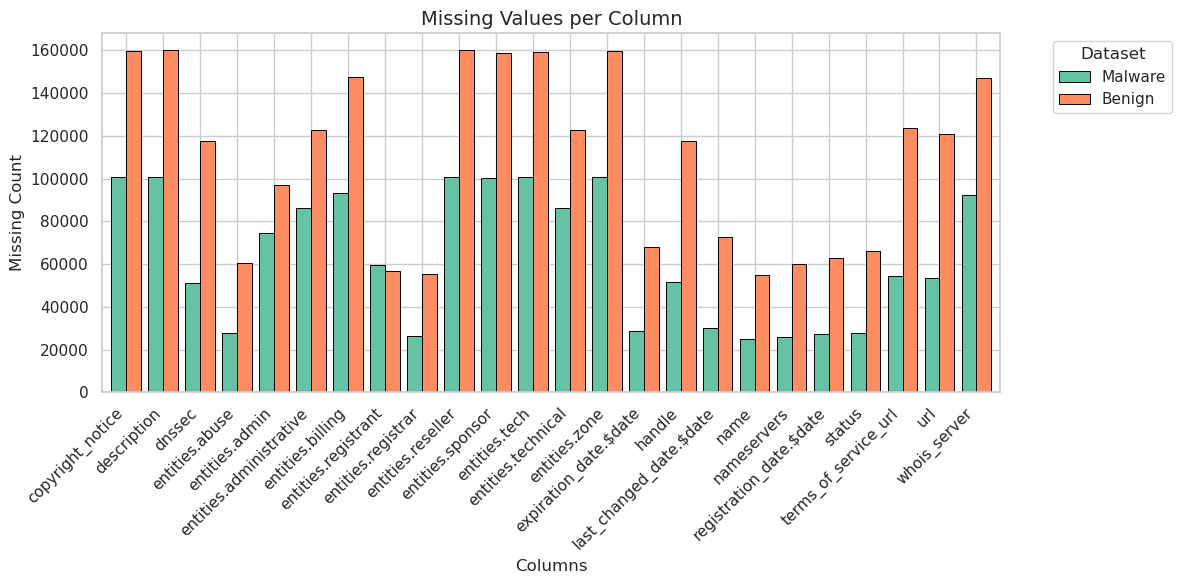

In [16]:
# Compute and plot missing value counts for columns in both datasets

missing_counts = pd.DataFrame({
    "Malware": malware_df.isna().sum(),
    "Benign": benign_df.isna().sum()
})

# Keep only columns with at least one missing value
missing_counts = missing_counts[(missing_counts["Malware"] > 0) | (missing_counts["Benign"] > 0)]

# Plot as grouped bar chart
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_counts.plot(
    kind="bar",
    color=colors,
    figsize=(12, 6),
    width=0.8,
    edgecolor="black",
    linewidth=0.7
)

ax.set_title("Missing Values per Column", fontsize=14)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


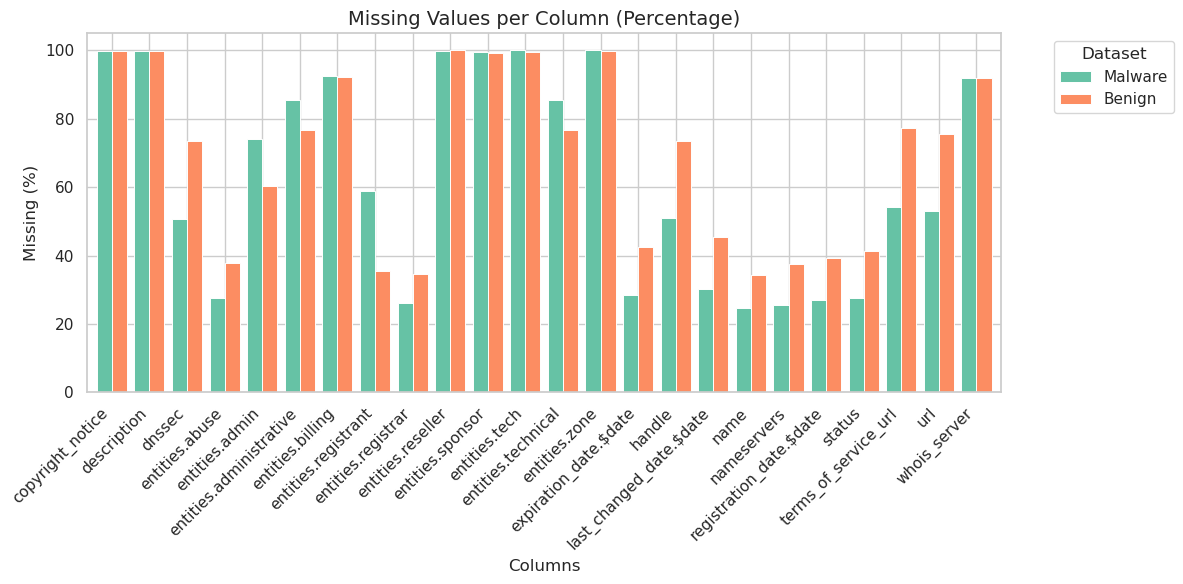

In [17]:
# Compute percentage of missing values for each column

missing_pct = pd.DataFrame({
    "Malware": malware_df.isna().mean() * 100,
    "Benign": benign_df.isna().mean() * 100
})

# Filter to columns with at least some missing data
missing_pct = missing_pct[(missing_pct["Malware"] > 0) | (missing_pct["Benign"] > 0)]

# Plot
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2", n_colors=2)

ax = missing_pct.plot(
    kind="bar",
    color=colors,
    figsize=(12, 6),
    width=0.8,
    linewidth=0.7
)

ax.set_title("Missing Values per Column (Percentage)", fontsize=14)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [18]:
def cohens_h(p1: float, p2: float) -> float:
    """
    Compute Cohen's h — effect size between two proportions.
    """
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))


# Compute missingness effect sizes between classes
effect_stats = {}

for col in benign_df.columns:
    benign_pct  = benign_df[col].isna().mean()
    malware_pct = malware_df[col].isna().mean()
    h_value     = abs(cohens_h(benign_pct, malware_pct))

    effect_stats[col] = {
        "benign_missing_pct":  benign_pct,
        "malware_missing_pct": malware_pct,
        "cohens_h":            h_value
    }

results_df = pd.DataFrame(effect_stats).T.sort_values("cohens_h", ascending=False)

print("Top fields by missingness-based class separation (Cohen's h):")
display(results_df.head(10))

# Identify low-signal features
low_effect_threshold = 0.2
low_effect_cols = results_df[results_df["cohens_h"] < low_effect_threshold].index.tolist()

print(f"\nFeatures recommended for drop (Cohen's h < {low_effect_threshold}):")
print(low_effect_cols)


Top fields by missingness-based class separation (Cohen's h):


,benign_missing_pct,malware_missing_pct,cohens_h
terms_of_service_url,0.772444,0.541727,0.492703
entities.registrant,0.353919,0.590007,0.477488
url,0.755294,0.530865,0.474098
dnssec,0.734056,0.507792,0.471569
handle,0.734619,0.510946,0.466532
last_changed_date.$date,0.454956,0.300866,0.319418
expiration_date.$date,0.426150,0.283199,0.300244
entities.admin,0.604906,0.739726,0.288646
status,0.412600,0.276979,0.286635
registration_date.$date,0.393869,0.269629,0.264942



Features recommended for drop (Cohen's h < 0.2):
['entities.registrar', 'entities.tech', 'entities.zone', 'entities.sponsor', 'entities.reseller', 'entities.billing', 'copyright_notice', 'whois_server', 'description', 'domain_name']


In [19]:
def is_missing(x) -> int:
    """
    Return 1 if the value is considered missing (NaN, empty string, empty list/array), else 0.
    """
    if isinstance(x, (list, np.ndarray)):
        return int(len(x) == 0)
    if isinstance(x, str) and x.strip() == "":
        return 1
    if pd.isna(x):
        return 1
    return 0


# Add labels and combine the two datasets
benign_df["label"] = 0
malware_df["label"] = 1
combined_df = pd.concat([benign_df, malware_df], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")

# Columns to consider for analysis (RDAP-related)
candidate_cols = [
    'handle', 'name', 'whois_server', 'terms_of_service_url', 'copyright_notice',
    'description', 'last_changed_date.$date', 'registration_date.$date',
    'expiration_date.$date', 'url', 'entities.registrant', 'entities.abuse',
    'entities.admin', 'entities.registrar', 'nameservers', 'status',
    'entities.technical', 'entities.administrative', 'entities.billing',
    'dnssec', 'entities.sponsor', 'entities.zone', 'entities.tech', 'entities.reseller'
]

chi_stats = {}

for col in candidate_cols:
    if col not in combined_df.columns:
        continue

    # Binary indicator for missingness
    missing_indicator = combined_df[col].apply(is_missing)
    missing_rate = missing_indicator.mean()

    # Contingency table between missingness and label
    contingency = pd.crosstab(missing_indicator, combined_df["label"])

    if contingency.shape[1] == 2:
        chi2, p_value, _, _ = chi2_contingency(contingency)
    else:
        p_value = 1.0  # Degenerate case (e.g., only one class present)

    chi_stats[col] = {
        "missing_rate": missing_rate,
        "p_value": p_value,
        "contingency_table": contingency
    }

    print(f"\nColumn: {col}")
    print(f"  Missing rate: {missing_rate:.2f}")
    print(f"  Chi-square p-value: {p_value:.4f}")
    print(f"  Contingency table:\n{contingency}")

# Final decision: Drop columns with >90% missing and no class-association
drop_candidates = [
    col for col, stat in chi_stats.items()
    if stat["missing_rate"] > 0.90 and stat["p_value"] > 0.05
]

print("\nColumns recommended for drop (missing > 90% and chi-square p > 0.05):")
print(drop_candidates)


Combined dataset shape: (260809, 26)

Column: handle
  Missing rate: 0.65
  Chi-square p-value: 0.0000
  Contingency table:
label        0      1
handle               
0        42461  49301
1       117539  51508

Column: name
  Missing rate: 0.31
  Chi-square p-value: 0.0000
  Contingency table:
label       0      1
name                
0      104921  75853
1       55079  24956

Column: whois_server
  Missing rate: 0.92
  Chi-square p-value: 0.2693
  Contingency table:
label              0      1
whois_server               
0              12883   8240
1             147117  92569

Column: terms_of_service_url
  Missing rate: 0.68
  Chi-square p-value: 0.0000
  Contingency table:
label                      0      1
terms_of_service_url               
0                      36409  46198
1                     123591  54611

Column: copyright_notice
  Missing rate: 1.00
  Chi-square p-value: 0.0233
  Contingency table:
label                  0       1
copyright_notice                
0     

In [20]:
# Identify features with >70% missing values in either dataset

threshold = 0.70  # 70% threshold - base on observation of missingness

malware_missing_pct = malware_df.isna().mean()
benign_missing_pct  = benign_df.isna().mean()

malware_high_missing = malware_missing_pct[malware_missing_pct > threshold].index
benign_high_missing  = benign_missing_pct[benign_missing_pct > threshold].index

# Union of columns that exceed threshold in either dataset
features_high_missing = set(malware_high_missing).union(benign_high_missing)

print(f"Columns with >{int(threshold * 100)}% missing in at least one dataset:")
for col in sorted(features_high_missing):
    print(f" - {col}")


Columns with >70% missing in at least one dataset:
 - copyright_notice
 - description
 - dnssec
 - entities.admin
 - entities.administrative
 - entities.billing
 - entities.reseller
 - entities.sponsor
 - entities.tech
 - entities.technical
 - entities.zone
 - handle
 - terms_of_service_url
 - url
 - whois_server


### Inspection of columns which should be dropped according to statistical analysis

In [21]:
# Preview value counts for high-missing columns (top 5 values only)

for col in sorted(features_high_missing):
    print(f"\nColumn: {col}")

    print("Benign:")
    print(benign_df[col].value_counts(dropna=False).head(5))

    print("Malware:")
    print(malware_df[col].value_counts(dropna=False).head(5))

    print("-" * 60)



Column: copyright_notice
Benign:
copyright_notice
NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                159777
Auteursrechtvoorbehoud: Niets uit deze publ

In [22]:
# Inspect unique values in selected structured fields

print("Unique values in benign_df['description']:")
print(benign_df["description"].explode().dropna().unique())

print("\nValue counts in malware_df['copyright_notice']:")
print(malware_df["copyright_notice"].explode().dropna().value_counts())


Unique values in benign_df['description']:
['This is a public suffix'
 'The TLD is not associated with, or sponsored by, any national or international government agency or branch of the armed forces in any nation.']

Value counts in malware_df['copyright_notice']:
copyright_notice
Auteursrechtvoorbehoud: Niets uit deze publicatie mag zonder voorafgaande uitdrukkelijke toestemming van SIDN worden verveelvoudigd, openbaar gemaakt, worden opgeslagen in een gegevensbestand of worden overgezonden, in welke vorm dan ook, elektronisch, mechanisch, door middel van opname of anderszins. Voor registrars geldt dit voorbehoud onverkort, behoudens redelijkerwijs noodzakelijke verveelvoudigingen of openbaarmakingen ten behoeve van de werkzaamheden van registrars, zoals vermeld in de 'Algemene voorwaarden voor registrars'. Elk gebruik van deze informatie voor commerci�le of reclamedoeleinden of soortgelijke activiteiten, is expliciet verboden en tegen overtreding van dat verbod zal worden opgetreden.

In [23]:
def make_hashable(x):
    """
    Convert x into a hashable type.
    If x is a dict, convert it to a tuple of sorted key-value pairs.
    If x is a list, recursively convert each element.
    Otherwise, return x as-is.
    """
    if isinstance(x, dict):
        # Convert dictionary into a tuple of sorted key-value pairs
        return tuple(sorted((k, make_hashable(v)) for k, v in x.items()))
    elif isinstance(x, list):
        # Convert each element in the list and then make the list a tuple.
        return tuple(make_hashable(item) for item in x)
    else:
        return x

# Iterate over columns_to_drop and display unique values
for col in drop_candidates:
    # Explode the column (if applicable), drop NA, and convert values to hashable types
    exploded_values = combined_df[col].explode().dropna().apply(make_hashable)
    
    # Now get unique values and their counts
    unique_vals = exploded_values.value_counts()
    
    print(f"Unique values for column '{col}':")
    print(unique_vals)
    print("\n")


Unique values for column 'whois_server':
whois_server
whois.nic.uk                  2045
whois.nic.site                1616
whois.nic.br                  1537
whois.id                      1418
whois.nic.xyz                  961
                              ... 
whois.porkbun.com                1
whois.cira.ca                    1
whois.instra.com                 1
whois.cctld.kg                   1
whois.french-connexion.com       1
Name: count, Length: 244, dtype: int64


Unique values for column 'description':
description
This is a public suffix                                                                                                                          35
The TLD is not associated with, or sponsored by, any national or international government agency or branch of the armed forces in any nation.    34
AsiaInfo                                                                                                                                          1
Copyright © Ilya O. Levi

### Dropping the columns

In [24]:
# Final cleanup: drop high-missing and low-signal columns
# Construct full drop list (includes manually flagged 'name')
columns_to_drop = list(features_high_missing.union(drop_candidates)) + ["name"]

print("Columns to drop:")
for col in columns_to_drop:
    print(f" - {col}")

# Ensure 'dnssec' is kept
if "dnssec" in columns_to_drop:
    columns_to_drop.remove("dnssec")

# Drop from both datasets
benign_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")
malware_df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# Normalize 'dnssec': fill missing with False and cast to bool
for df in [benign_df, malware_df]:
    df["dnssec"] = df["dnssec"].fillna(False).astype(bool)


Columns to drop:
 - entities.zone
 - entities.sponsor
 - description
 - dnssec
 - copyright_notice
 - handle
 - entities.administrative
 - entities.technical
 - entities.tech
 - url
 - whois_server
 - entities.admin
 - entities.billing
 - entities.reseller
 - terms_of_service_url
 - name


/tmp/ipykernel_219508/378214162.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["dnssec"] = df["dnssec"].fillna(False).astype(bool)
/tmp/ipykernel_219508/378214162.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["dnssec"] = df["dnssec"].fillna(False).astype(bool)


In [25]:
render_dataframe(benign_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrant,entities.abuse,entities.registrar,nameservers,status,dnssec,label
0,00000fs3085d.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
1,0000100b00e9.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
2,0000100q012c.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
3,0000102n02c4.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
4,0000102n02d5.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
5,0000102n03d3.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
6,0000102n0434.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
7,000010560066.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
8,0000105600be.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0
9,000010640021.han2.savba.sk,2023-09-14T00:00:00Z,2003-09-16T00:00:00Z,2024-09-16T00:00:00Z,[{'name': 'VSSA-0001'}],[{'email': ''}],[{'name': 'VSSA-0001'}],"['AURIGA.TA3.SK', 'NS.SAV.SK', 'SAVBA.SAVBA.SK']",['ok'],False,0


In [26]:
render_dataframe(malware_df, max_rows=100, max_cols=50)

,domain_name,last_changed_date.$date,registration_date.$date,expiration_date.$date,entities.registrar,entities.abuse,nameservers,status,dnssec,entities.registrant,label
0,irradiateher.com,2023-10-25T09:40:06Z,2022-11-23T13:12:23Z,2024-11-23T13:12:23Z,"[{'handle': '48', 'type': 'entity', 'name': 'eNom, LLC'}]","[{'type': 'entity', 'name': '', 'email': ''}]","['NS1.PUBLICDNSSERVICE.COM', 'NS2.PUBLICDNSSERVICE.COM', 'NS3.PUBLICDNSSERVICE.COM', 'NS4.PUBLICDNSSERVICE.COM']",['client transfer prohibited'],False,nan,1
1,eloquentcs.com,2023-06-16T09:46:02Z,2013-06-13T16:04:43Z,2024-06-13T16:04:43Z,"[{'handle': '146', 'type': 'entity', 'name': 'GoDaddy.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'abuse@godaddy.com'}]","['NS59.DOMAINCONTROL.COM', 'NS60.DOMAINCONTROL.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,1
2,www.neutralsystemsolution.space,2023-08-31T17:10:49Z,2023-06-02T08:35:48Z,2024-06-02T23:59:59Z,[{'name': 'PDR Ltd. d/b/a PublicDomainRegistry.com'}],[{'email': ''}],"['NS1.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM', 'NS2.VERIFICATION-HOLD.SUSPENDED-DOMAIN.COM']",['client transfer prohibited'],False,[{'name': 'none'}],1
3,www.drshiwanijainpainclinic.com,2022-10-13T18:35:46Z,2021-08-31T12:20:02Z,2024-08-31T12:20:02Z,"[{'name': 'GoDaddy.com, LLC'}]",[{'email': ''}],"['NS1.DNS-PARKING.COM', 'NS2.DNS-PARKING.COM']","['client delete prohibited', 'client renew prohibited', 'client transfer prohibited', 'client update prohibited']",False,"[{'name': 'Domains By Proxy, LLC'}]",1
4,mkt9136.com,2023-08-11T09:31:50Z,2017-09-12T15:20:17Z,2024-09-12T15:20:17Z,"[{'handle': '292', 'type': 'entity', 'name': 'MarkMonitor Inc.'}]","[{'type': 'entity', 'name': '', 'email': 'abusecomplaints@markmonitor.com'}]","['NS1.ACOUSTIC-ADM.COM', 'NS2.ACOUSTIC-ADM.COM', 'NS3.ACOUSTIC-ADM.COM', 'NS4.ACOUSTIC-ADM.COM']","['client delete prohibited', 'client transfer prohibited', 'client update prohibited']",False,nan,1
5,www.ninjacondoms.com,2023-07-28T20:28:00Z,2005-10-22T18:20:32Z,2024-10-22T18:20:32Z,"[{'name': 'OnlineNIC, Inc.'}]",[{'email': ''}],"['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']","['client delete prohibited', 'client transfer prohibited']",False,[{'name': ''}],1
6,gabbyloans.com,2019-10-30T18:13:37Z,2019-10-30T17:42:10Z,2024-10-30T17:42:10Z,"[{'handle': '886', 'type': 'entity', 'name': 'Domain.com, LLC'}]","[{'type': 'entity', 'name': '', 'email': 'compliance@domain-inc.net'}]","['NS1.DIGITALOCEAN.COM', 'NS2.DIGITALOCEAN.COM', 'NS3.DIGITALOCEAN.COM']",['active'],False,nan,1
7,www.poczta-polska.e-kei.pl,2021-08-27T14:01:01Z,2013-11-04T12:26:26Z,nan,[{'name': 'cyber_Folks S.A.'}],[{'email': ''}],"['NS1.KEI.PL', 'NS2.KEI.PL']",nan,False,[{'name': ''}],1
8,xinchaocfcddl.org,nan,nan,nan,nan,nan,nan,nan,False,nan,1
9,siwakuposo.com,nan,nan,nan,nan,nan,nan,nan,False,nan,1


In [27]:
# Drop rows where all feature fields (excluding id/label) are missing

excluded_cols = ["domain_name", "label", "dnssec"]
cols_to_check = [col for col in benign_df.columns if col not in excluded_cols]

# Create row-wise masks for full-NaN rows
mask_benign  = benign_df[cols_to_check].isna().all(axis=1)
mask_malware = malware_df[cols_to_check].isna().all(axis=1)

# Count and drop
print(f"Rows dropped (benign):  {mask_benign.sum()}")
print(f"Rows dropped (malware): {mask_malware.sum()}")

benign_df.drop(index=benign_df[mask_benign].index, inplace=True)
malware_df.drop(index=malware_df[mask_malware].index, inplace=True)

print("Final shapes:", benign_df.shape, malware_df.shape)


Rows dropped (benign):  55079
Rows dropped (malware): 25068
Final shapes: (104921, 11) (75741, 11)


In [28]:
benign_df["status"].value_counts()

status
[client transfer prohibited]                                                                                 28292
[ok]                                                                                                         13120
[active]                                                                                                     12196
[client delete prohibited, client renew prohibited, client transfer prohibited, client update prohibited]     6115
[client delete prohibited, client transfer prohibited]                                                        2938
                                                                                                             ...  
[client transfer prohibited, server transfer prohibited, server update prohibited]                               1
[client transfer prohibited, ok, pending delete, server hold]                                                    1
[server hold, client transfer prohibited, client delete prohibited, auto 

In [29]:
# Inspect value distribution in 'status' field (benign only)
if "status" in benign_df.columns:
    print("Benign 'status' field value counts:")
    print(benign_df["status"].value_counts(dropna=False))

# Inspect unique keys in nested entity fields (across both datasets)
entity_columns = ['entities.abuse', 'entities.registrar', 'entities.registrant', 'entities.admin']

for col in entity_columns:
    if col not in benign_df.columns:
        continue

    unique_keys = set()
    for cell in benign_df[col].dropna():
        if isinstance(cell, list):
            for entry in cell:
                if isinstance(entry, dict):
                    unique_keys.update(entry.keys())

    print(f"\nUnique keys in '{col}':")
    print(sorted(unique_keys))


Benign 'status' field value counts:
status
[client transfer prohibited]                                                                                        28292
[ok]                                                                                                                13120
[active]                                                                                                            12196
NaN                                                                                                                 10937
[client delete prohibited, client renew prohibited, client transfer prohibited, client update prohibited]            6115
                                                                                                                    ...  
[inactive, server transfer prohibited, server hold, pending delete, server update prohibited, redemption period]        1
[client transfer prohibited, server transfer prohibited, renew period]                                 

In [30]:
# Inspect distribution of 'dnssec' values after conversion
for df_name, df in [("Benign", benign_df), ("Malware", malware_df)]:
    print(f"\n{df_name} dataset - 'dnssec' value counts:")
    print(df["dnssec"].value_counts(dropna=False))



Benign dataset - 'dnssec' value counts:
dnssec
False    102043
True       2878
Name: count, dtype: int64

Malware dataset - 'dnssec' value counts:
dnssec
False    75106
True       635
Name: count, dtype: int64


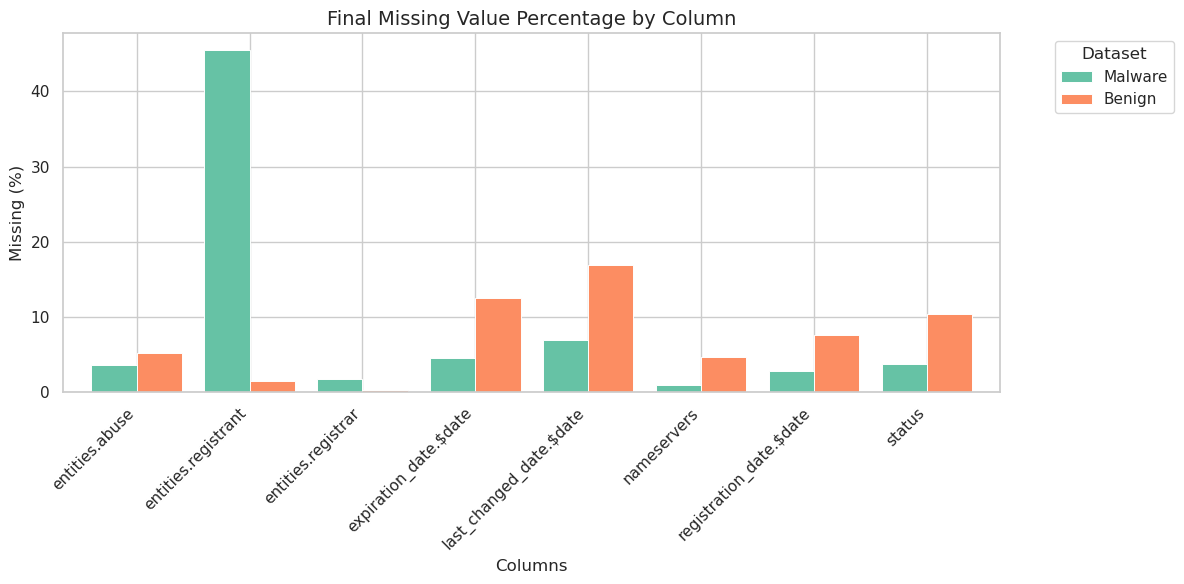

In [31]:
# Final plot: percentage of missing values per column (shared columns only)

missing_pct = pd.DataFrame({
    "Malware": malware_df.isna().mean() * 100,
    "Benign": benign_df.isna().mean() * 100
})

missing_pct = missing_pct[(missing_pct["Malware"] > 0) | (missing_pct["Benign"] > 0)]

sns.set_theme(style="whitegrid")
colors = sns.color_palette("Set2", 2)

ax = missing_pct.plot(
    kind="bar",
    color=colors,
    figsize=(12, 6),
    width=0.8,
    linewidth=0.7
)

ax.set_title("Final Missing Value Percentage by Column", fontsize=14)
ax.set_xlabel("Columns", fontsize=12)
ax.set_ylabel("Missing (%)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [32]:
print(malware_df["entities.registrant"].value_counts())
print(benign_df["entities.registrant"].value_counts())

entities.registrant
[{'name': ''}]                                                                                                                                                                    11023
[{'type': 'entity', 'name': 'Privacy service provided by Withheld for Privacy ehf'}]                                                                                               3562
[{'name': 'Privacy service provided by Withheld for Privacy ehf'}]                                                                                                                 2370
[{'type': 'entity'}]                                                                                                                                                               1792
[{'name': 'Domains By Proxy, LLC'}]                                                                                                                                                1596
                                                            

# Phase 3: Prepare the dataframe for transformer training
For training the transformer, it is neccessary to create a one concatenated string with fields from analyzed dataframe

In [33]:
def stringify_value(value):
    """
    Convert scalar or nested value to string. Empty or None becomes 'NA'.
    """
    if isinstance(value, dict):
        return json.dumps(value)
    return str(value) if value else "NA"


def format_entity_entry(entry, canonical_keys):
    """
    Format a single entity entry (dict) into a string using key:value pairs.
    """
    parts = []
    for key in canonical_keys:
        val = entry.get(key, "NA")
        val_str = stringify_value(val).strip() or "NA"
        parts.append(f"{key}: {val_str}")
    return " | ".join(parts)


def process_entity_field(entity_list, canonical_keys, label):
    """
    Format an entity list field into a labeled string.
    """
    if not isinstance(entity_list, list) or len(entity_list) == 0:
        return f"{label}: NA"
    return f"{label}: " + " ; ".join(format_entity_entry(e, canonical_keys) for e in entity_list)


def process_list_field(values, label, sep=", "):
    """
    Format a list-based field (e.g., status) as a string.
    """
    if not isinstance(values, list) or len(values) == 0:
        return f"{label}: NA"
    cleaned = [str(v).strip() for v in values if v]
    return f"{label}: {sep.join(cleaned)}" if cleaned else f"{label}: NA"


def concat_rdap_fields(row):
    """
    Construct a formatted string from selected RDAP fields for model input.
    """
    CLS = "[CLS]"
    SEP = "[SEP]"
    toks = []

    # Domain name
    domain = str(row.get("domain_name", "NA")).lower().lstrip("www.")
    toks.append(f"domain: {domain}")

    # Entities
    toks.append(process_entity_field(row.get("entities.abuse", []),      ['name', 'type', 'email', 'url', 'tel', 'handle'], "abuse"))
    toks.append(process_entity_field(row.get("entities.registrar", []),  ['name', 'email', 'whois_server', 'url', 'tel', 'handle', 'type'], "registrar"))
    toks.append(process_entity_field(row.get("entities.registrant", []), ['name', 'email', 'whois_server', 'url', 'rir', 'tel', 'handle', 'type'], "registrant"))
    toks.append(process_entity_field(row.get("entities.admin", []),      ['name', 'email', 'handle', 'type'], "admin"))

    # Lists
    toks.append(process_list_field(row.get("nameservers", []), "nameservers"))
    toks.append(process_list_field(row.get("status", []), "status"))

    return f"{CLS} " + f" {SEP} ".join(toks) + f" {SEP}"


In [34]:
# Generate input strings for both datasets
benign_df["input_string"] = benign_df.apply(concat_rdap_fields, axis=1)
malware_df["input_string"] = malware_df.apply(concat_rdap_fields, axis=1)

# Combine into a training DataFrame
combined_df = pd.concat(
    [benign_df[["input_string", "label"]], malware_df[["input_string", "label"]]],
    ignore_index=True
).sample(frac=1, random_state=42).reset_index(drop=True)

# Preview
display(render_dataframe(combined_df))


,input_string,label
0,"[CLS] domain: ariake.estate [SEP] abuse: name: NA | type: entity | email: abuse@gmo.jp | url: NA | tel: NA | handle: 576DC194A8684EE79376A6B82064CCFB-DONUTS [SEP] registrar: name: GMO Internet Group, Inc. d/b/a Onamae.com | email: NA | whois_server: NA | url: https://rdap.donuts.co/rdap/entity/49 | tel: NA | handle: 49 | type: entity [SEP] registrant: name: Yoshiaki Ariake | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: entity [SEP] admin: NA [SEP] nameservers: ns1.dns.ne.jp, ns2.dns.ne.jp [SEP] status: active [SEP]",0
1,"[CLS] domain: tjeme.com.mx [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NEUBOX Internet SA de CV | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: CAROL.NS.CLOUDFLARE.COM, KURT.NS.CLOUDFLARE.COM [SEP] status: NA [SEP]",1
2,"[CLS] domain: benevolentdifferentlymeadow.com [SEP] abuse: name: NA | type: entity | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: eNom, LLC | email: NA | whois_server: NA | url: NA | tel: NA | handle: 48 | type: entity [SEP] registrant: NA [SEP] admin: NA [SEP] nameservers: NS1.PUBLICDNSSERVICE.COM, NS2.PUBLICDNSSERVICE.COM, NS3.PUBLICDNSSERVICE.COM, NS4.PUBLICDNSSERVICE.COM [SEP] status: client transfer prohibited [SEP]",1
3,"[CLS] domain: micapublicitatesatumare.ro [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: NAMEBOX S.R.L. | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: NA | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.NAMEBOX.RO, NS2.NAMEBOX.RO [SEP] status: o k [SEP]",1
4,"[CLS] domain: api.cdnverificationlinks.com [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: Vautron Rechenzentrum AG | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: Registrant State/Province: doonde | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.ZAP-HOSTING.COM, NS2.ZAP-HOSTING.COM [SEP] status: ok [SEP]",1
5,"[CLS] domain: galwangedi.com [SEP] abuse: name: NA | type: entity | email: abuse@porkbun.com | url: NA | tel: NA | handle: NA [SEP] registrar: name: Porkbun LLC | email: NA | whois_server: NA | url: NA | tel: NA | handle: 1861 | type: entity [SEP] registrant: NA [SEP] admin: NA [SEP] nameservers: NS1.DIGITALOCEAN.COM, NS2.DIGITALOCEAN.COM, NS3.DIGITALOCEAN.COM [SEP] status: client delete prohibited, client transfer prohibited [SEP]",1
6,"[CLS] domain: ssl.prom.st [SEP] abuse: name: NA | type: NA | email: NA | url: NA | tel: NA | handle: NA [SEP] registrar: name: EPAG Domainservices GmbH | email: NA | whois_server: NA | url: NA | tel: NA | handle: NA | type: NA [SEP] registrant: name: registrant-name: Sergii Negodiuk (O0011006004) | email: NA | whois_server: NA | url: NA | rir: NA | tel: NA | handle: NA | type: NA [SEP] admin: NA [SEP] nameservers: NS1.PROMDNS.NET, NS2.PROMDNS.NET, NS3.PROMDNS.NET [SEP] status: ok [SEP]",0
7,"[CLS] domain: spacepilot.scot [SEP] abuse: name: Abuse Contact | type: entity | email: abuse@corehub.net | url: NA | tel: +34.935275235 | handle: NOT APPLICABLE [SEP] registrar: name: COREhub | email: support@corehub.net | whois_server: NA | url: https://rdap.nic.scot/rdap/entity/15 | tel: +34.935207834 | handle: 15 | type: entity [SEP] registrant: name: NA | email: NA | whois_server: whois.corehub.net | url: https://rdap.nic.scot/rdap/entity/core15OAZLxcC135 | rir: NA | tel: NA | handle: CORE15OAZLXCC135 | type: entity [SEP] admin: NA [SEP] nameservers: dns1.name-services.com, dns2.name-services.com, dns5.name-services.com, dns4.na

Save the final DataFrame to a CSV file

In [35]:
# save_path = project_root / "datasets" / "malware" / "rdap_malware_preprocessed.csv"
# combined_df.to_csv(save_path, index=False)